# Confidence Intervals and Replication for yes/no outcomes

## A first calculation

Let's consider a simple experiment where we want to measure the probability of a yes/no outcome, e.g. the probability of a (possibly unfair) unfair coinflip coming up heads, or an electorate's forced-choice favorable/unfavorable response to a candidate.  There is some underlying probability $p_\text{true}$ which we don't know but want to measure, and we'll do an experiment where gather the yes/no outcome $N$ times.

In [1]:
p_true = 0.5
N = 100

We perform this experiment once, and our sample result ($p_1$) indicates our estimate for $p_\text{true}$.

In [2]:
n_heads = 52
p_1 = n_heads / N
p_1

0.52

We want to articulate the uncertainty in our estimate, which certainly ought to be equivalent to saying something about how much our estimate would change if we were to repeat the experiment.  We do this by articulating a confidence interval at some level $C_\text{level}$, e.g. 80%.

In [3]:
C_level = 0.8

Using the usual definition of confidence interval, we find it as follows:
* For a normal distribution (entirely independent of the particulars of our experiment) figure out how many standard deviations we would need to go out from the mean to capture $C_\text{level}$ of the probability a normal distribution.  This is given by the z-score of $(1-C_\text{level})/2$ because that's the size of the tails on each side of the distribution that we want to exclude.
* Calculate the standard error in our sample, which for a yes/no distribution is given by $\sqrt{p_1(1-p_1)/N}$.
* Then our confidence interval is given by our sample mean $\pm$ the z-score multiplied by the standard error.

In [4]:
import math
from scipy import stats

def confidence_interval(sample_p, sample_n, conf_level):
    sem = math.sqrt(sample_p * (1 - sample_p) / sample_n)  
    z_score = -stats.norm.ppf((1 - conf_level) / 2)
    return {"mean": sample_p, "plusminus": z_score * sem}

ci = confidence_interval(p_1, N, C_level)
print(f"CI: {ci['mean']:.5f} ± {ci['plusminus']:.5f}")


CI: 0.52000 ± 0.06403


OK, now let's ask: what's the probability that if we repeat the experiment we'll get a new sample mean that falls within our confidence interval?  

Answering that requires asking about the distribution around the **actual underlying distribution** given by $p_\text{true}$:
* Calculate the probability that a sample of size $N$ (drawn from the true distribution) will have a mean below the bottom of our interval.
* Similarly, calculate the probability that the sample will have a mean above the top of our interval.
* Sum those two values to get the probabily that the mean is outside our interval, then subtract from 1 to get the probability that the result of the replicated experiment is inside our interval.

In [5]:
def prob_within_ci(underlying_p, sample_N, ci):
    std = math.sqrt(underlying_p * (1 - underlying_p) / sample_N)  
    # probability of falling below the interval
    ci_min = ci["mean"] - ci["plusminus"]
    z_score_min = (ci_min - underlying_p) / std
    prob_below = stats.norm.cdf(z_score_min)
    # probability of falling above the interval
    ci_max = ci["mean"] + ci["plusminus"]
    z_score_max = (ci_max - underlying_p) / std
    prob_above = 1 - stats.norm.cdf(z_score_max)
    return 1 - prob_below - prob_above

print(f"Probability of replicated experiment falling within CI: {prob_within_ci(p_true, N, ci):.5f}")

Probability of replicated experiment falling within CI: 0.76429


Note that the result of this calculation -- i.e. the probabily of replication -- is **not** the same as the confidence interval's level.  This may or may not be a surprise to you, but it's definitely _not_ the common casual understanding.  

Note that "probability of replication" as used here means specifically "probability of the second experiment falling within the confidence interval of the first experiment".  I suspect there's probably a better term for this concept (whereas "probability of replication" is likely to mean different things in different contexts.)

## On what does the probability of replication depend?

So now let's ask how the probability of replication depends on our various inputs:
* The underlying probability $p_\text{true}$
* Sample size $N$
* Confidence interval level $C_\text{level}$
* The result of our first experiment $p_1$.


In [6]:
def prob_of_replicating_first_experiment(underlying_p, sample_N, conf_level, p_1):
    ci = confidence_interval(p_1, sample_N, conf_level)
    return prob_within_ci(underlying_p, sample_N, ci)

First, let's see how the probability of replication changes as we change $p_1$:

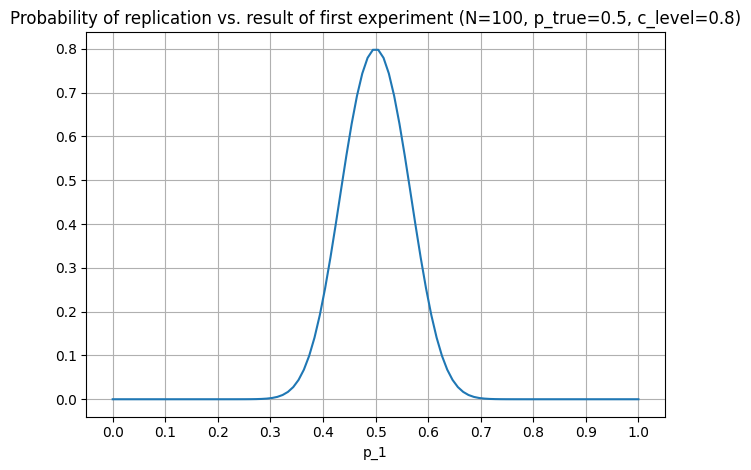

In [19]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

points = [(x, prob_of_replicating_first_experiment(p_true, N, C_level, x)) for x in np.linspace(0, 1, 100)]
plt.plot(*zip(*points))

def usual_plot_setup(x_label="", title="", legend=True):
    plt.grid(True)
    if legend:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 0.9))
    plt.title(title)
    plt.xlabel(x_label)
    plt.tight_layout()

usual_plot_setup(x_label="p_1", title="Probability of replication vs. result of first experiment (N=100, p_true=0.5, c_level=0.8)", legend=False)
ax = plt.gca()  # get current axis
ax.set_xticks(np.arange(0, 1.1, 0.1))  # Set x-ticks every 0.1 increment
plt.show()



What this shows us is that if -- as is likely! -- our sample result is close to $p_\text{true}$ then our probabily of replication is close to the confidence interval level.  But if we're unlucky, our sample result is far from $p_\text{true}$ and then our probability of replication is much lower than the confidence interval suggests.

Let's see how this depends on a few other factors. 

### Dependence on confidence level

What happens if we repeat this calculation at various confidence levels?  Not surprisingly, as we expand the confidence level (and thus the size of the interval) the probability of replication increases.  Nonetheless, if we end up "unlucky" in our first experiment, the probability of replication will still be quite low.

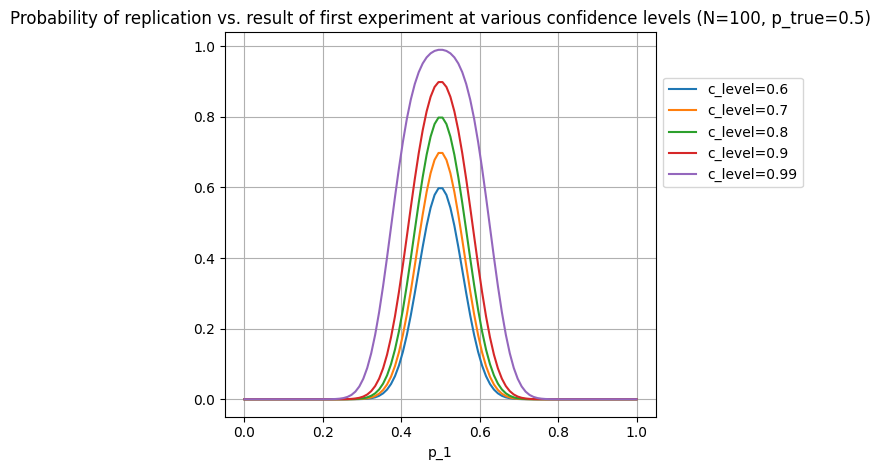

In [14]:
c_levels = [0.6, 0.7, 0.8, 0.9, 0.99]
for cl in c_levels:
    points = [(x, prob_of_replicating_first_experiment(p_true, N, cl, x)) for x in np.linspace(0, 1, 100)]
    plt.plot(*zip(*points), label=f"c_level={cl}")

usual_plot_setup(x_label="p_1", title="Probability of replication vs. result of first experiment at various confidence levels (N=100, p_true=0.5)")
plt.show()


### Dependence on $p_\text{true}$

As we vary $p_\{true\}$, we see that the for the most part the probabilty of replication is smooth and symmetric based on how close $p_1$ is to  $p_\text{true}$, though there are some edge effects at the extremes.

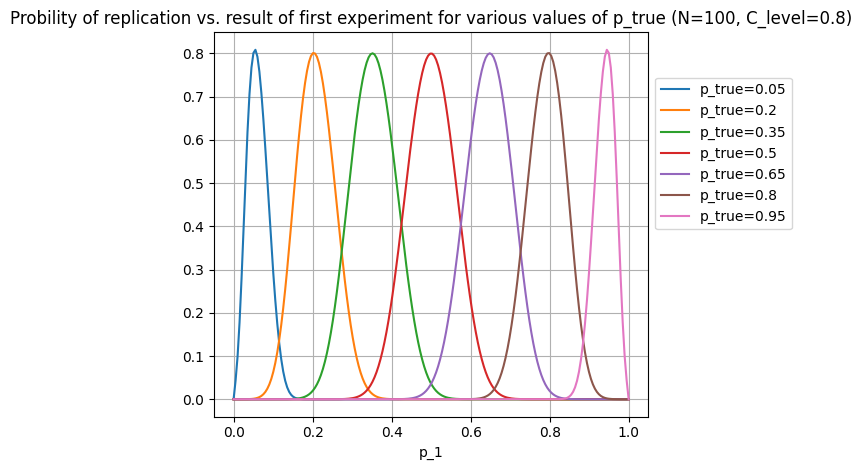

In [15]:
p_true_values = [0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]
for pt in p_true_values:
    points = [(x, prob_of_replicating_first_experiment(pt, N, C_level, x)) for x in np.linspace(0, 1, 200)]
    plt.plot(*zip(*points), label=f"p_true={pt}")

usual_plot_setup(x_label="p_1", title="Probility of replication vs. result of first experiment for various values of p_true (N=100, C_level=0.8)")
plt.show()


### Dependence on $N$

Let's see what happens if we repeat this calculation at various sample sizes.  As N increases, the probability of replication goes _down_.  This result may initially seem counterintuitive, but note that we are plotting vs. $p_1$.  As $N$ increases, the probability of ending up with $p_1$ far from the true value goes down -- but if we do end up "unlucky" it is hard to recover.  Whereas if we have a small sample size, we are more likely to end up "unlucky" but if we do, we are more likely to recover.

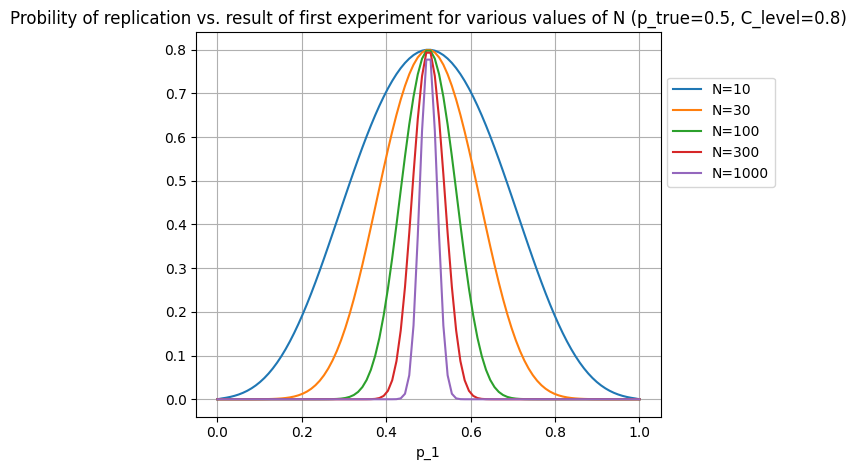

In [16]:
N_values = [10, 30, 100, 300, 1000]
for n in N_values:
    points = [(x, prob_of_replicating_first_experiment(p_true, n, C_level, x)) for x in np.linspace(0, 1, 100)]
    plt.plot(*zip(*points), label=f"N={n}")

usual_plot_setup(x_label="p_1", title="Probility of replication vs. result of first experiment for various values of N (p_true=0.5, C_level=0.8)")
plt.show()


## Even before the first experiment

Above we plotted the probability of replication vs $p_1$, which is useful for developing some intuition as to what's going on but doesn't actually mimic what happens "in the real world".  In the real world we won't know how close our $p_1$ is to $p_\text{true}$, and the calculation we're really interested in would help us understand the following:

Let's assume we're going to do the experiment twice.  **Before we even do the first experiment, what's the probability that the result of the second will fall in the confidence interval of the result of the first?**

To answer this, we need to do the calculation above but integrated over the probability distribution of $p_1$.  To start, let's look at the probability of replication vs. N for various confidence levels.

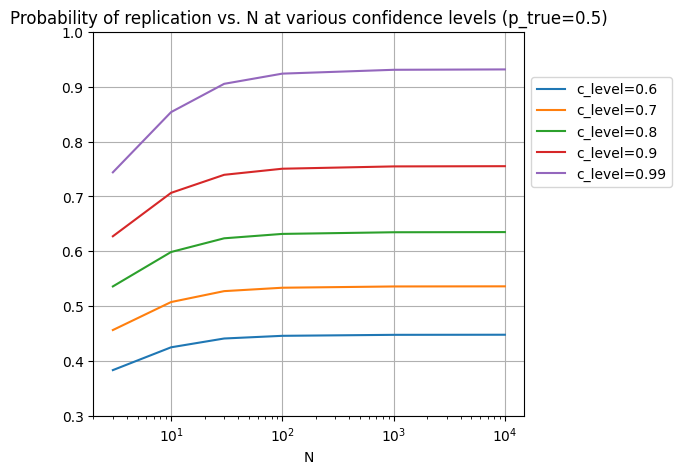

In [29]:
from scipy.stats import norm
from scipy.integrate import quad

def prob_replication(underlying_p, sample_N, conf_level):
    pdf_p1 = lambda p1: norm.pdf(p1, loc=underlying_p, scale=math.sqrt(underlying_p * (1 - underlying_p) / sample_N))
    replication_prob = lambda p1: prob_of_replicating_first_experiment(underlying_p, sample_N, conf_level, p1)
    weighted_prob = lambda p1: pdf_p1(p1) * replication_prob(p1)
    return quad(weighted_prob, 0, 1)[0]  # scipy's integration method

N_values = [3, 10, 30, 100, 1000, 10000]
c_levels = [0.6, 0.7, 0.8, 0.9, 0.99]
for cl in c_levels:
    points = [(n, prob_replication(0.2, n, cl)) for n in N_values]
    plt.plot(*zip(*points), label=f"c_level={cl}")

usual_plot_setup(x_label="N", title="Probability of replication vs. N at various confidence levels (p_true=0.5)")
ax = plt.gca()
ax.set_xscale('log')
ax.set_yticks(np.arange(0.3, 1.1, 0.1))
plt.show()

It looks like these values approach asymptotic limits for large $N$; let's see more precisely how this apparent limit dependends on the confidence level.

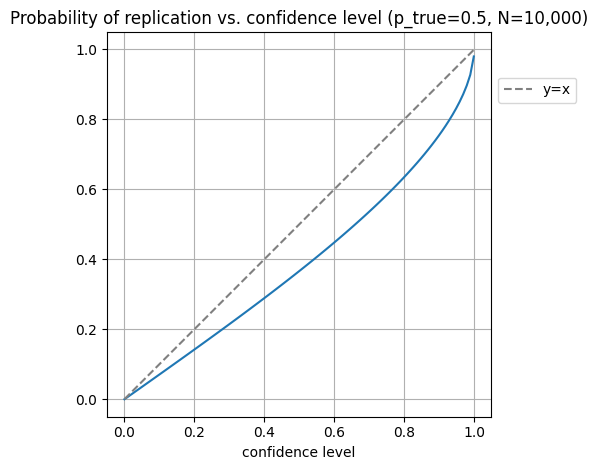

In [41]:
cl_values = np.linspace(0.001, 0.999, 100)
points = [(cl, prob_replication(p_true, 10000, cl)) for cl in cl_values]
plt.plot(*zip(*points))

# Add gray dotted line at y=x
plt.plot(cl_values, cl_values, 'gray', linestyle='--', label="y=x")

usual_plot_setup(x_label="confidence level", title="Probability of replication vs. confidence level (p_true=0.5, N=10,000)", legend=True)
ax = plt.gca()  # Get the current axes
ax.set_aspect('equal', 'box')
plt.show()

Somewhat to my surprise this graph does not seem sensitive to $p_\text{true}$ -- when I plot the curves for $p$=0.01, 0.2, 0.35, and 0.5 they all overlap and you can only see the top line.  At small values of $N$ (i.e. prior to the asymptotic limit) this is not the case.

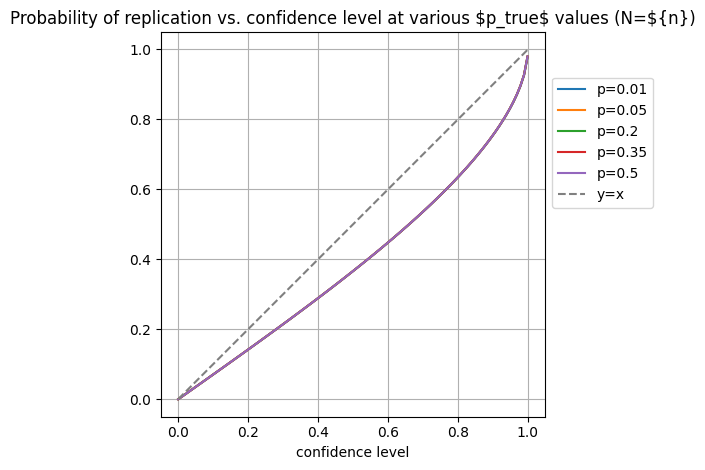

In [42]:
def plot_replication_vs_clevel_at_various_p_true(n):
    cl_values = np.linspace(0.001, 0.999, 100)
    p_values = [0.01, 0.05, 0.2, 0.35, 0.5]
    for p in p_values:
      points = [(cl, prob_replication(p, n, cl)) for cl in cl_values]
      plt.plot(*zip(*points), label=f"p={p}")

    # Add gray dotted line at y=x
    plt.plot(cl_values, cl_values, 'gray', linestyle='--', label="y=x")

    usual_plot_setup(x_label="confidence level", title="Probability of replication vs. confidence level at various $p_true$ values (N=${n})", legend=True)
    ax = plt.gca()  # Get the current axes
    ax.set_aspect('equal', 'box')
    plt.show()


plot_replication_vs_clevel_at_various_p_true(10000)

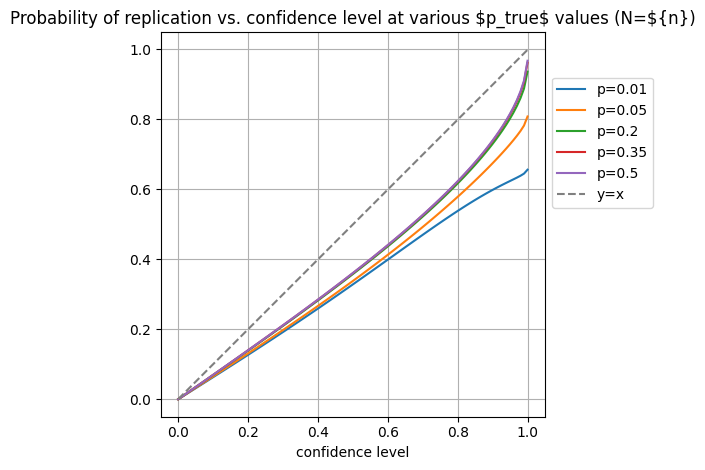

In [43]:
plot_replication_vs_clevel_at_various_p_true(20)